# Load Libraries

In [10]:
# core packages
import pandas as pd
import numpy as np
import os
import sqlite3
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sqlalchemy import create_engine
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# jupyter specifications
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# set core path
path = '/Users/Mark/Documents/Github/Fantasy_Football/'

# change directory temporarily to helper scripts
os.chdir(path + 'Scripts/Analysis/Helper_Scripts')

# load custom plot functions
from my_plot import PrettyPlot
PrettyPlot(plt)

# load custom helper functions and ensure lightgbm runs
from helper_functions import *
os.environ['KMP_DUPLICATE_LIB_OK']='True';

# User Inputs

In [12]:
#==========
# General Setting
#==========

db_name = 'Model_Inputs.sqlite3'

# set to position to analyze: 'RB', 'WR', 'QB', or 'TE'
set_pos = 'RB'


#==========
# Postgres Database
#==========

# postgres login information
pg_log = {
    'USER': 'postgres',
    'PASSWORD': 'Ctdim#1bf!!!!!',
    'HOST': 'localhost',
    'PORT': '5432', 
    'DATABASE_NAME': 'fantasyfootball'
}

# create engine for connecting to database
engine = create_engine('postgres+psycopg2://{}:{}@{}:{}/{}'.format(pg_log['USER'], pg_log['PASSWORD'], pg_log['HOST'],
                                                                   pg_log['PORT'], pg_log['DATABASE_NAME']))

# specify schema and table to write out intermediate results
table_info = {
    'engine': engine,
    'schema': 'websitedev',
}

#==========
# Data Filtering
#==========

# set year to analyze
set_year = 2019
earliest_year = 2001

# set required touches (or pass thrown) and games for consideration
req_games = 8
req_touch = 50


#==========
# Fantasy Point Values
#==========

# define point values for all statistical categories
pass_yd_per_pt = 0.04 
pass_td_pt = 4
int_pts = -2
sacks = -1
rush_yd_per_pt = 0.1 
rec_yd_per_pt = 0.1
rush_rec_td = 7
ppr = 0.5
fumble = -2

# creating dictionary containing point values for each position
pts_dict = {}
pts_dict['QB'] = [pass_yd_per_pt, pass_td_pt, rush_yd_per_pt, rush_rec_td, int_pts, sacks]
pts_dict['RB'] = [rush_yd_per_pt, rec_yd_per_pt, ppr, rush_rec_td]
pts_dict['WR'] = [rec_yd_per_pt, ppr, rush_rec_td]
pts_dict['TE'] = [rec_yd_per_pt, ppr, rush_rec_td]


#==========
# Model Settings
#==========

pos['QB']['earliest_year'] = 2009
pos['RB']['earliest_year'] = 2004
pos['WR']['earliest_year'] = 1999
pos['TE']['earliest_year'] = 1999

pos['QB']['skip_years'] = 1
pos['RB']['skip_years'] = 3
pos['WR']['skip_years'] = 3
pos['TE']['skip_years'] = 3

pos['QB']['corr_cutoff'] = 0.25
pos['RB']['corr_cutoff'] = 0.2
pos['WR']['corr_cutoff'] = 0.25
pos['TE']['corr_cutoff'] = 0.25

pos['QB']['vif_thresh'] = 5
pos['RB']['vif_thresh'] = 5
pos['WR']['vif_thresh'] = 5
pos['TE']['vif_thresh'] = 5

pos['QB']['iter_rounds'] = 20
pos['RB']['iter_rounds'] = 20
pos['WR']['iter_rounds'] = 20
pos['TE']['iter_rounds'] = 20

# whether or not to plot feature importances following modeling
plot_importance = True

In [13]:
#==========
# Pull and clean compiled data
#==========

# connect to database and pull in positional data
conn = sqlite3.connect(path + 'Data/' + db_name)
df = pd.read_sql_query('SELECT * FROM ' + set_pos + '_' + str(set_year), con=conn)

# ay = pd.read_sql_query('SELECT * FROM AirYards', con=sqlite3.connect(path + 'Data/Season_Stats.sqlite3'))
# df = pd.merge(df, ay, how='inner', left_on=['player', 'year'], right_on=['player', 'year'])

# split old and new to filter past years based on touches.
# leave all new players in to ensure everyone gets a prediction
old = df[(df[pos[set_pos]['touch_filter']] > req_touch) & (df.games > req_games) & (df.year < set_year-1)].reset_index(drop=True)
this_year = df[df.year==set_year-1]

# merge old and new back together after filtering
df = pd.concat([old, this_year], axis=0)

# create dataframes to store results
df_train_results = pd.DataFrame([old.player, old.year]).T
df_test_results = pd.DataFrame([this_year.player, this_year.year]).T

# calculate FP and generate list of relevant metrics
df = calculate_fp(df, pts_dict, pos=set_pos).reset_index(drop=True)

# Merge and Clean Data Files

In [14]:
#---------
# QB Dictionary
#---------

pos['QB']['med_features'] = ['fp', 'qb_tds','qb_rating', 'qb_yds', 'pass_off', 'qb_complete_pct', 'qb_td_pct', 
                             'sack_pct', 'avg_pick', 'sacks_allowed', 'qbr', 'adj_yd_per_att', 'adj_net_yd_per_att',
                             'int', 'int_pct', 'rush_att', 'rush_yds', 'rush_td', 'rush_yd_per_att',
                             'rz_20_pass_complete', 'rz_20_pass_att',
                               'rz_20_complete_pct', 'rz_20_pass_yds', 'rz_20_pass_td', 'rz_20_int',
                               'rz_10_pass_complete', 'rz_10_pass_att', 'rz_10_complete_pct',
                               'rz_10_pass_yds', 'rz_10_pass_td', 'rz_10_int', 'rz_20_rush_att',
                               'rz_20_rush_yds', 'rz_20_rush_td', 'rz_20_rush_pct', 'rz_10_rush_att',
                               'rz_10_rush_yds', 'rz_10_rush_td', 'rz_10_rush_pct', 'rz_5_rush_att',
                               'rz_5_rush_yds', 'rz_5_rush_td', 'rz_5_rush_pct']
pos['QB']['max_features'] = ['fp', 'qb_rating', 'qb_yds', 'qb_tds', 'int', 'int_pct', 'sack_pct', 'rush_yd_per_att']
pos['QB']['age_features'] = ['fp', 'qb_rating', 'qb_yds', 'qb_complete_pct', 'qb_td_pct', 'sack_pct', 
                             'avg_pick', 'qbr', 'int', 'int_pct', 'rush_att', 'rush_yds', 'rush_td', 'rush_yd_per_att']
pos['QB']['sum_features'] = ['qb_tds', 'qb_yds', 'fourth_qt_comeback', 'game_winning_drives', 'fp']


#---------
# RB Dictionary
#---------

# median feature categories
pos['RB']['med_features'] = ['fp', 'tgt', 'receptions', 'total_touches', 'rush_yds', 'rec_yds', 
                           'rush_yd_per_game', 'rec_yd_per_game', 'rush_td', 'games_started', 
                           'qb_rating', 'qb_yds', 'pass_off', 'tm_rush_td', 'tm_rush_yds', 
                           'tm_rush_att', 'adjust_line_yds', 'ms_rush_yd', 'ms_rec_yd', 'ms_rush_td',
                           'avg_pick', 'fp_per_touch', 'team_rush_avg_att',
                            'rz_20_rush_att', 'rz_20_rush_yds', 'rz_20_rush_td', 'rz_20_tgt', 'rz_20_receptions', 
                            'rz_20_catch_pct', 'rz_20_rec_yds', 'rz_20_rec_tds',
                            'rz_10_rush_att', 'rz_10_rush_yds', 'rz_10_rush_td', 'rz_10_tgt', 'rz_10_receptions', 
                            'rz_10_catch_pct', 'rz_10_rec_yds', 'rz_10_rec_tds',
                            'rz_5_rush_att', 'rz_5_rush_yds', 'rz_5_rush_td']

# sum feature categories
pos['RB']['sum_features'] = ['total_touches', 'att', 'total_yds', 'rush_td', 'fp', 'rec_yds', 
                             'rush_yds', 'qb_yds']

# max feature categories
pos['RB']['max_features'] = ['fp', 'rush_td', 'tgt', 'rush_yds', 'rec_yds', 'total_yds', 
                             'rush_yd_per_game', 'rec_yd_per_game', 'ms_rush_yd']

# age feature categories
pos['RB']['age_features'] = ['fp', 'rush_yd_per_game', 'rec_yd_per_game', 'total_touches', 'receptions', 'tgt',
                             'ms_rush_yd', 'ms_rec_yd', 'available_rush_att', 'available_tgt', 'total_touches_sum',
                             'total_yds_sum', 'avg_pick', 'fp_per_touch', 'ms_rush_yd_per_att', 'ms_tgts',
                            'rz_20_rush_att', 'rz_20_rush_yds', 'rz_20_rush_td', 'rz_20_tgt', 'rz_20_receptions', 
                            'rz_20_catch_pct', 'rz_20_rec_yds', 'rz_20_rec_tds',
                            'rz_10_rush_att', 'rz_10_rush_yds', 'rz_10_rush_td', 'rz_10_tgt', 'rz_10_receptions', 
                            'rz_10_catch_pct', 'rz_10_rec_yds', 'rz_10_rec_tds',
                            'rz_5_rush_att', 'rz_5_rush_yds', 'rz_5_rush_td']


#---------
# WR Dictionary
#---------

# median feature categories
pos['WR']['med_features'] = ['fp', 'tgt', 'receptions', 'rec_yds', 'rec_yd_per_game', 'rec_td', 'games_started', 
                             'qb_rating', 'qb_yds', 'pass_off', 'ms_tgts', 'ms_rec_yd', 
                             'tm_net_pass_yds', 'avg_pick',  'rz_20_tgt', 'rz_20_receptions', 
                            'rz_20_catch_pct', 'rz_20_rec_yds', 'rz_20_rec_tds',
                             'rz_10_tgt', 'rz_10_receptions', 
                            'rz_10_catch_pct', 'rz_10_rec_yds', 'rz_10_rec_tds']
# sum feature categories
pos['WR']['sum_features'] = ['receptions', 'rec_yds', 'tgt']

# max feature categories
pos['WR']['max_features'] = ['fp', 'rec_td', 'tgt', 'ms_tgts', 'ms_rec_yd', 'rec_yd_per_game',
                             'rz_20_tgt', 'rz_20_receptions', 
                             'rz_20_catch_pct', 'rz_20_rec_yds', 'rz_20_rec_tds',]

# age feature categories
pos['WR']['age_features'] = ['fp', 'rec_yd_per_game', 'receptions', 'tgt', 'ms_tgts', 'ms_rec_yd', 
                             'avg_pick', 'ms_yds_per_tgts', 'rz_20_tgt', 'rz_20_receptions', 
                            'rz_20_catch_pct', 'rz_20_rec_yds', 'rz_20_rec_tds',
                             'rz_10_tgt', 'rz_10_receptions', 
                            'rz_10_catch_pct', 'rz_10_rec_yds', 'rz_10_rec_tds',]

#---------
# TE Dictionary
#---------

# median feature categories
pos['TE']['med_features'] = ['fp', 'tgt', 'receptions', 'rec_yds', 'rec_yd_per_game', 'rec_td', 'games_started', 
                             'qb_rating', 'qb_yds', 'pass_off', 'ms_tgts', 'ms_rec_yd', 
                             'tm_net_pass_yds', 'avg_pick','rz_20_tgt', 'rz_20_receptions', 
                            'rz_20_catch_pct', 'rz_20_rec_yds', 'rz_20_rec_tds',
                             'rz_10_tgt', 'rz_10_receptions', 
                            'rz_10_catch_pct', 'rz_10_rec_yds', 'rz_10_rec_tds',]
# sum feature categories
pos['TE']['sum_features'] = ['receptions', 'rec_yds', 'tgt', 'rec_td', 'qb_yds']

# max feature categories
pos['TE']['max_features'] = ['fp', 'rec_td', 'tgt', 'ms_tgts', 'rec_yds', 'ms_rec_yd', 'rec_yd_per_game',
                             'rz_20_tgt', 'rz_20_receptions', 
                            'rz_20_catch_pct', 'rz_20_rec_yds', 'rz_20_rec_tds',
                             'rz_10_tgt', 'rz_10_receptions', 
                            'rz_10_catch_pct', 'rz_10_rec_yds', 'rz_10_rec_tds',]

# age feature categories
pos['TE']['age_features'] = ['fp', 'rec_yd_per_game', 'receptions', 'tgt', 'ms_tgts', 'ms_rec_yd', 
                             'avg_pick', 'ms_yds_per_tgts','rz_20_tgt', 'rz_20_receptions', 
                            'rz_20_catch_pct', 'rz_20_rec_yds', 'rz_20_rec_tds',
                             'rz_10_tgt', 'rz_10_receptions', 
                            'rz_10_catch_pct', 'rz_10_rec_yds', 'rz_10_rec_tds',]

Running Models for rush_yd_per_game
----------------------------------
Number of Training Samples: 347
Corr removed  267 / 288  features
Training Ensemble Model
2019-09-03 21:44:35
Completed 10/20 iterations
2019-09-03 21:44:51
Completed 20/20 iterations
     lgbm    xgb  lasso  ridge   rmse    mae  r2_pred  c_pred  r2_adp  c_adp
0   0.256  0.258  0.244  0.242  16.82  13.54    0.526   0.725   0.445  0.667
11  0.252  0.251  0.245  0.252  17.07  13.51    0.520   0.721   0.445  0.667
14  0.266  0.265  0.209  0.259  17.84  14.50    0.516   0.718   0.445  0.667
19  0.246  0.255  0.251  0.248  16.97  13.35    0.514   0.717   0.445  0.667
7   0.247  0.253  0.251  0.249  16.97  13.44    0.513   0.716   0.445  0.667
12  0.249  0.251  0.246  0.254  17.23  13.62    0.511   0.715   0.445  0.667
1   0.255  0.257  0.228  0.260  17.50  14.10    0.510   0.714   0.445  0.667
5   0.246  0.253  0.252  0.249  17.05  13.39    0.509   0.714   0.445  0.667
9   0.249  0.252  0.255  0.244  17.31  13.71    0.50

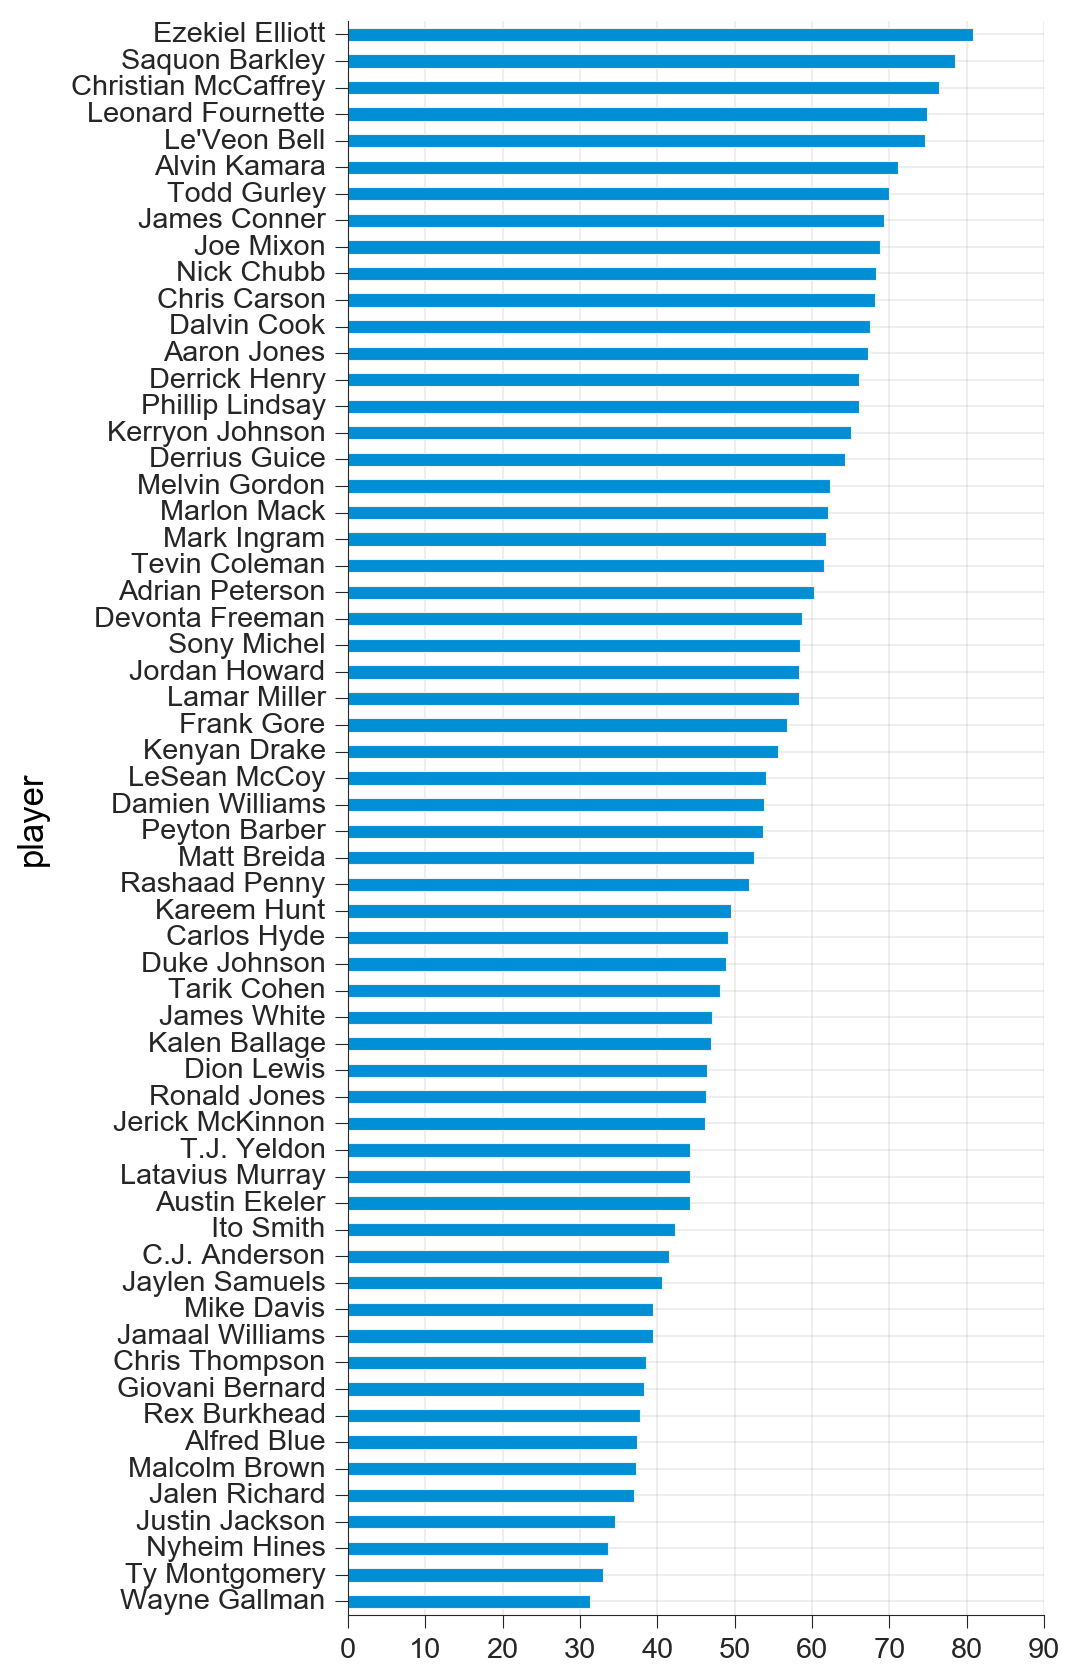

Running Models for rec_yd_per_game
----------------------------------
Number of Training Samples: 347
Corr removed  268 / 288  features
Training Ensemble Model
2019-09-03 21:45:14
Completed 10/20 iterations
2019-09-03 21:45:29
Completed 20/20 iterations
     lgbm    xgb  lasso  ridge   rmse   mae  r2_pred  c_pred  r2_adp  c_adp
5   0.245  0.244  0.255  0.256  10.05  7.54    0.444   0.666   0.109   0.33
7   0.247  0.243  0.254  0.256  10.05  7.54    0.444   0.667   0.109   0.33
11  0.259  0.256  0.222  0.263  10.16  7.68    0.444   0.667   0.109   0.33
19  0.248  0.242  0.254  0.256  10.07  7.54    0.443   0.665   0.109   0.33
9   0.251  0.249  0.255  0.245  10.04  7.58    0.442   0.665   0.109   0.33
13  0.249  0.247  0.256  0.249  10.05  7.59    0.442   0.665   0.109   0.33
18  0.260  0.263  0.212  0.265  10.31  7.83    0.442   0.665   0.109   0.33
12  0.257  0.257  0.223  0.263  10.18  7.64    0.437   0.661   0.109   0.33
1   0.261  0.260  0.211  0.267  10.25  7.78    0.436   0.661  

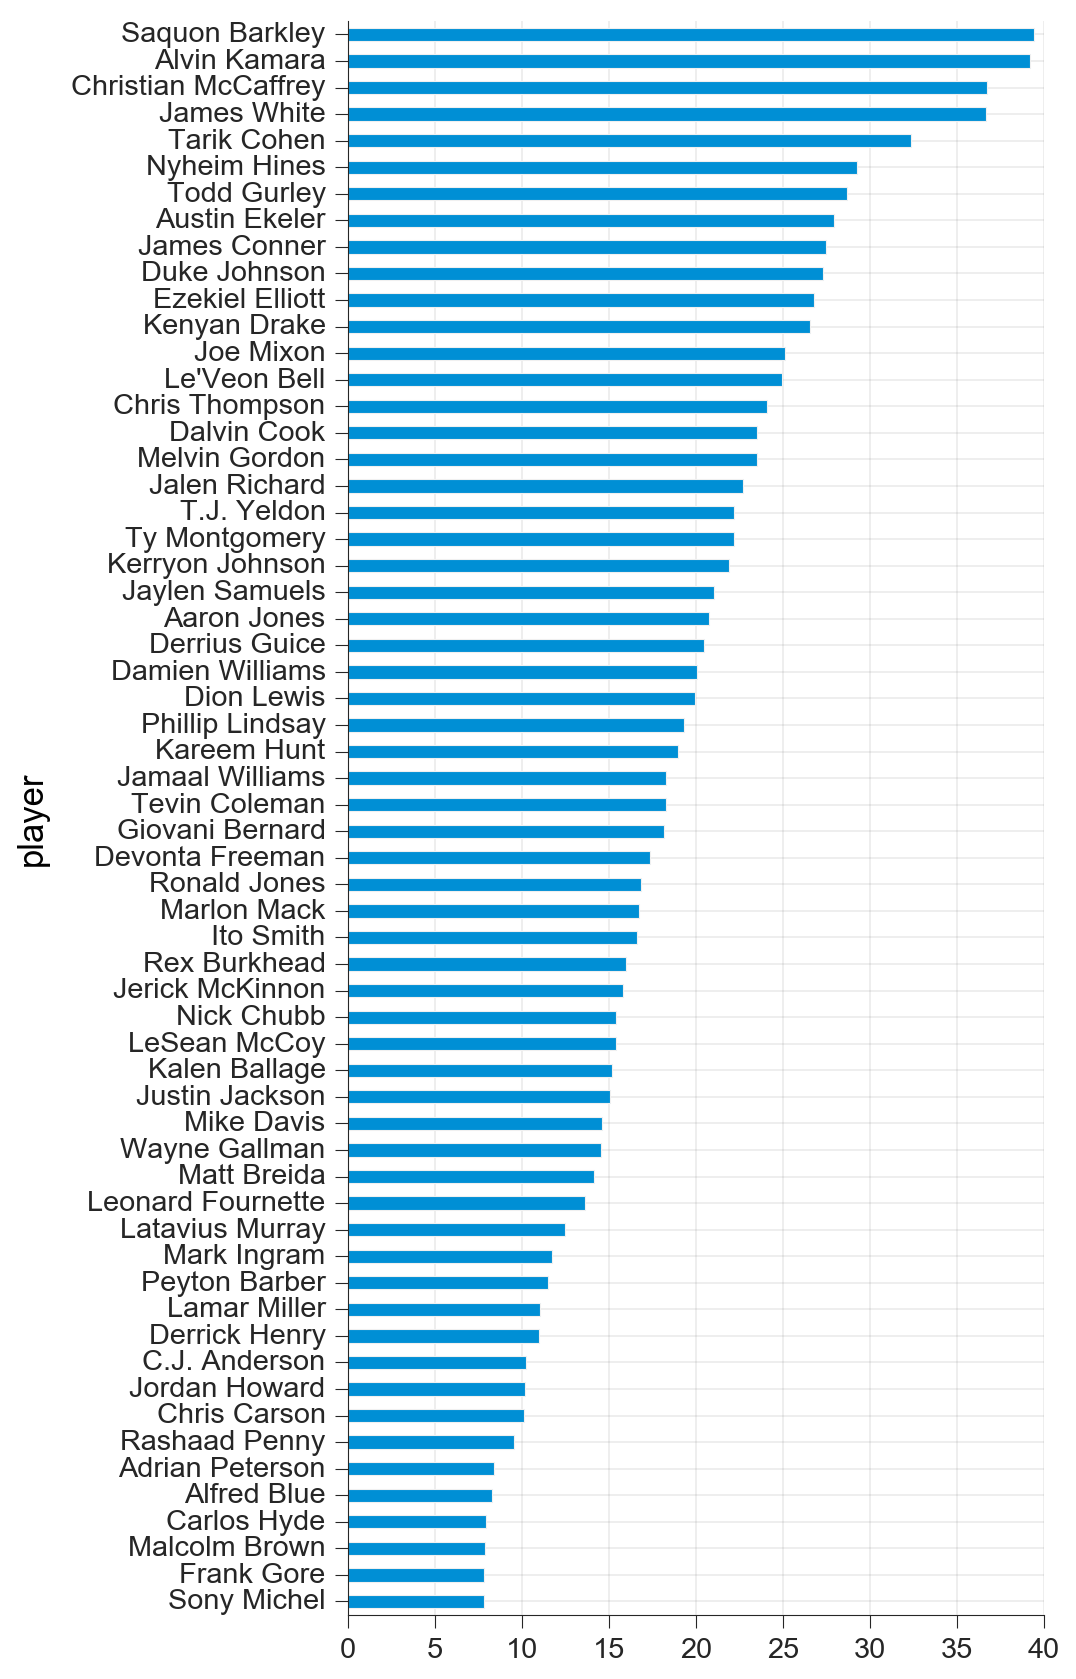

Running Models for rec_per_game
----------------------------------
Number of Training Samples: 347
Corr removed  266 / 288  features
Training Ensemble Model
2019-09-03 21:45:53
Completed 10/20 iterations
2019-09-03 21:46:09
Completed 20/20 iterations
     lgbm    xgb  lasso  ridge  rmse   mae  r2_pred  c_pred  r2_adp  c_adp
15  0.264  0.265  0.204  0.267  1.08  0.85    0.501   0.708   0.132  0.364
9   0.262  0.259  0.227  0.251  1.07  0.85    0.498   0.705   0.132  0.364
18  0.260  0.267  0.206  0.267  1.08  0.85    0.498   0.705   0.132  0.364
7   0.255  0.255  0.227  0.262  1.07  0.84    0.491   0.701   0.132  0.364
11  0.262  0.264  0.205  0.269  1.07  0.85    0.491   0.701   0.132  0.364
13  0.259  0.258  0.228  0.256  1.08  0.85    0.491   0.700   0.132  0.364
17  0.266  0.264  0.208  0.262  1.09  0.87    0.490   0.700   0.132  0.364
8   0.264  0.263  0.204  0.269  1.06  0.84    0.489   0.699   0.132  0.364
4   0.265  0.262  0.205  0.269  1.07  0.84    0.489   0.699   0.132  0.364

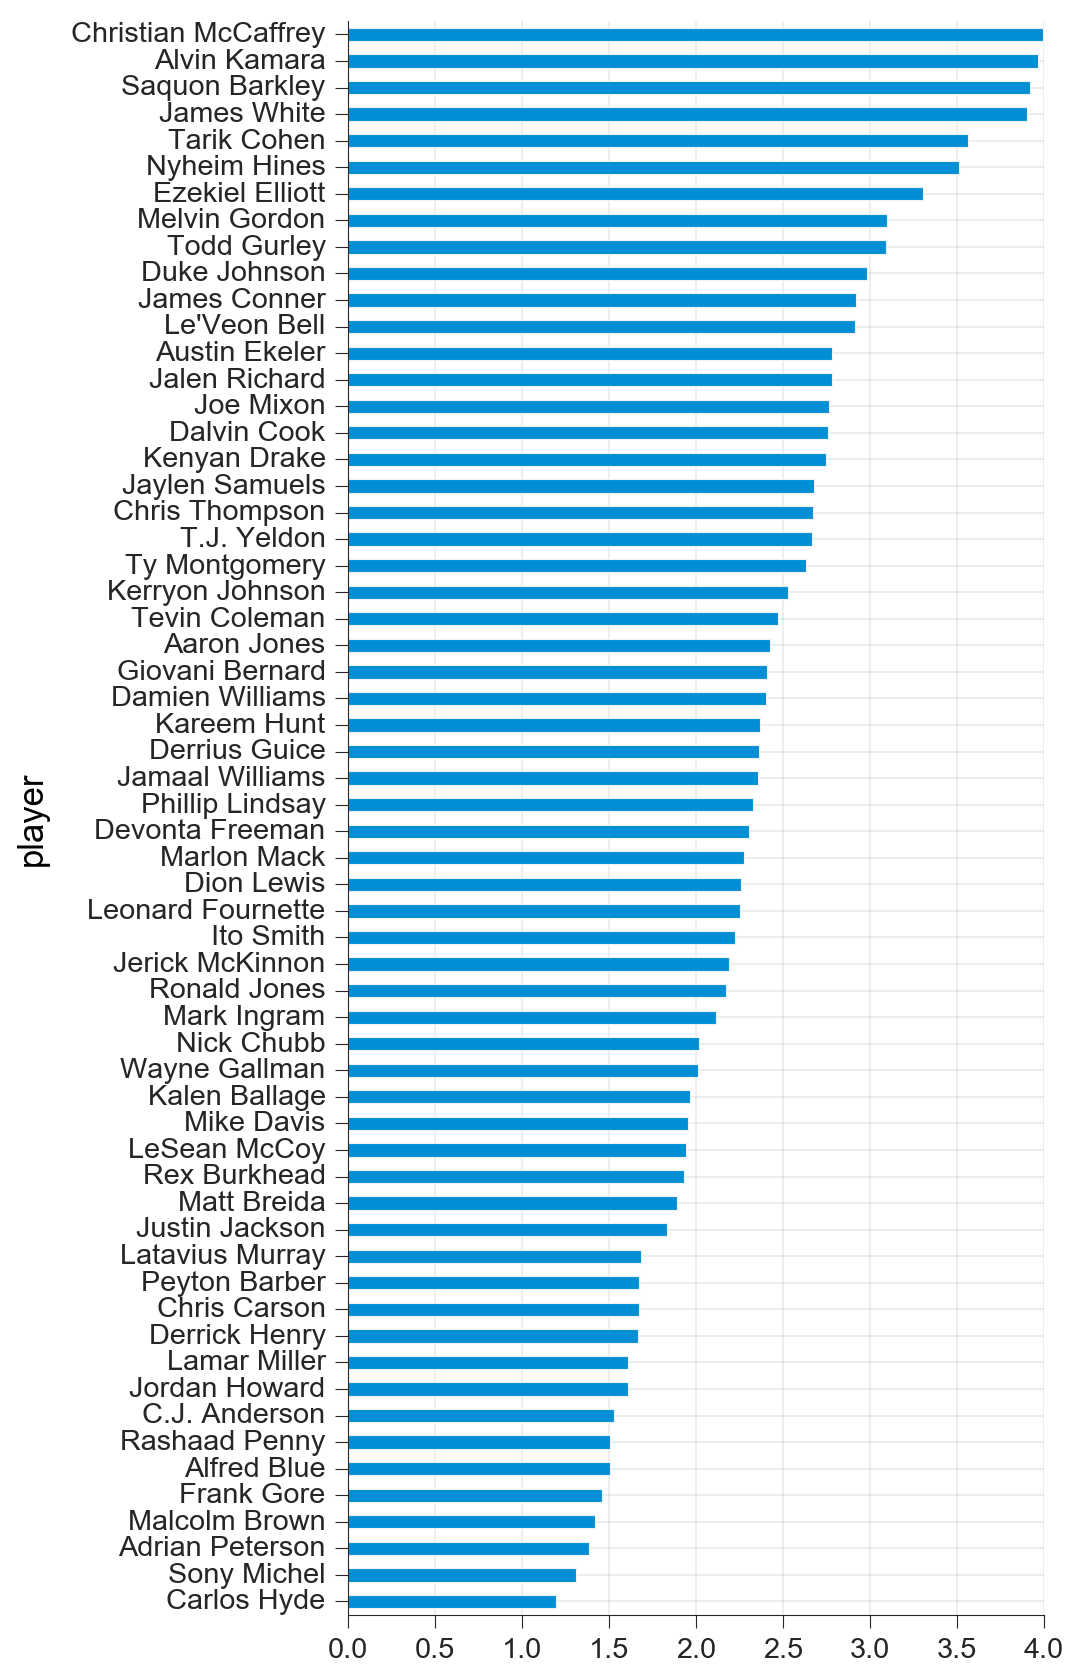

Running Models for td_per_game
----------------------------------
Number of Training Samples: 347
Corr removed  272 / 288  features
Training Ensemble Model
2019-09-03 21:46:31
Completed 10/20 iterations
2019-09-03 21:46:45
Completed 20/20 iterations
     lgbm    xgb  lasso  ridge  rmse   mae  r2_pred  c_pred  r2_adp  c_adp
7   0.257  0.257  0.226  0.261  0.25  0.19    0.327   0.572   0.318  0.564
19  0.259  0.256  0.225  0.260  0.25  0.19    0.322   0.568   0.318  0.564
5   0.257  0.257  0.226  0.260  0.25  0.20    0.316   0.562   0.318  0.564
4   0.259  0.254  0.226  0.260  0.25  0.20    0.314   0.561   0.318  0.564
12  0.254  0.257  0.227  0.261  0.25  0.20    0.310   0.557   0.318  0.564
18  0.256  0.256  0.228  0.260  0.25  0.20    0.309   0.556   0.318  0.564
15  0.259  0.254  0.227  0.260  0.25  0.20    0.308   0.555   0.318  0.564
11  0.252  0.258  0.228  0.262  0.25  0.20    0.307   0.554   0.318  0.564
6   0.259  0.254  0.228  0.258  0.25  0.20    0.306   0.553   0.318  0.564


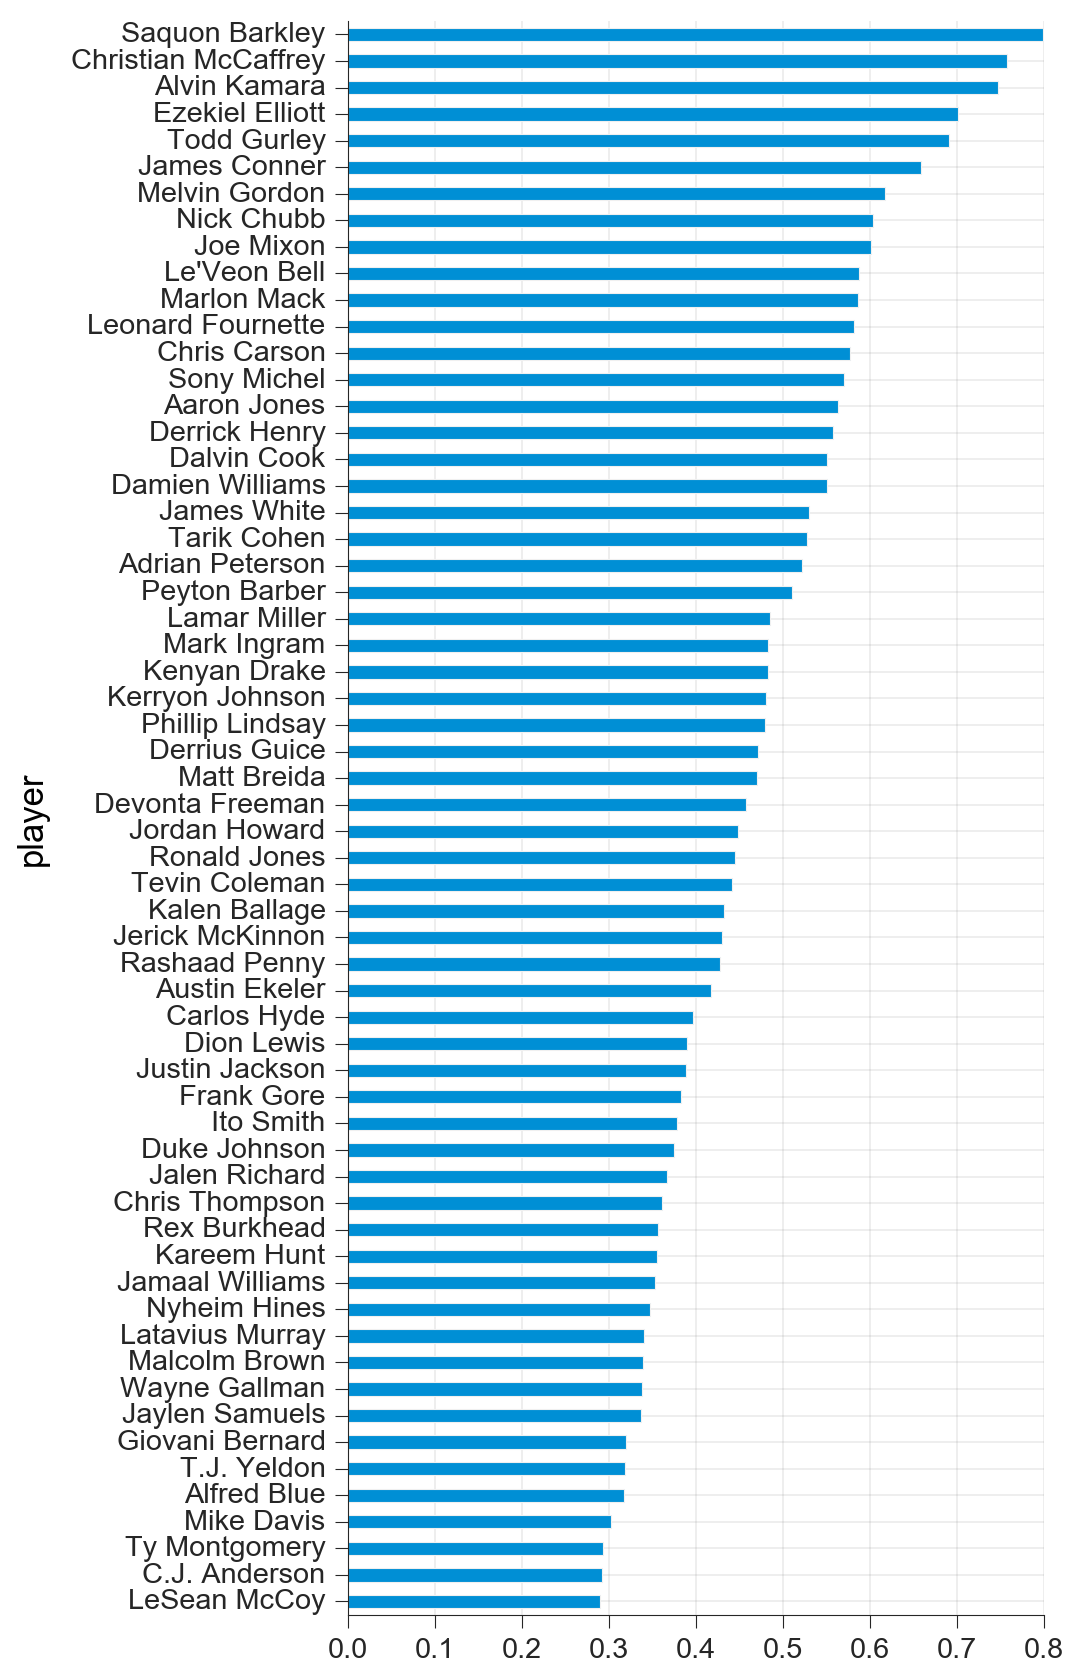

In [90]:
#==========
# Loop to create statistical predictions
#==========

output = {}


for metric in pos[set_pos]['metrics']:
    
    # print which metric is being calculated
    print('Running Models for ' + metric)
    print('----------------------------------')

    #--------
    # Create train and predict dataframes
    #--------
    
    # create training and prediction dataframes
    df_train, df_predict = features_target(df,
                                           pos[set_pos]['earliest_year'], set_year-1,
                                           pos[set_pos]['med_features'],
                                           pos[set_pos]['sum_features'],
                                           pos[set_pos]['max_features'],
                                           pos[set_pos]['age_features'],
                                           target_feature=metric)
    
    # drop any rows that have a null target value (likely due to injuries or other missed season)
    df_train = df_train.dropna(subset=['y_act']).reset_index(drop=True)
    df_train = df_train.fillna(df_train.mean())
    df_predict = df_predict.dropna().reset_index(drop=True)
    
    print('Number of Training Samples:', df_train.shape[0])

    #--------
    # Remove low correlation features and high VIF features
    #--------

    # remove low correlation features
    df_train, df_predict = corr_removal(df_train, df_predict, corr_cutoff=pos[set_pos]['corr_cutoff'])

    # select only features with low vif for modeling
    transformer = ReduceVIF(thresh=pos[set_pos]['vif_thresh'], scale=True, print_progress=False)
    df_train_ = transformer.fit_transform(df_train.drop(['y_act', 'player'], axis=1), df_train.y_act)

    # extract best columns and filter down df_predict
    best_cols = list(df_train_.columns)
    best_cols.extend(['player', 'year', 'avg_pick'])
    df_predict = df_predict[best_cols]
    df_predict = df_predict.loc[:,~df_predict.columns.duplicated()]

    # add target and filter down df_train
    best_cols.extend(['y_act', 'year', 'avg_pick'])
    df_train = df_train[best_cols]
    df_train = df_train.loc[:,~df_train.columns.duplicated()]

    df_train, df_predict = corr_collinear_removal(df_train, df_predict, 
                                                  corr_cutoff=pos[set_pos]['corr_cutoff'],
                                                  collinear_cutoff=0.7)

    #--------
    # Run ensemble model with parameter optimization
    #--------

    # generate a master dictionary of parameters
    param_list = [lgbm_params, xgb_params, lasso_params, ridge_params]
    est_names = ['lgbm', 'xgb', 'lasso', 'ridge']

    params = {}
    for i, param in enumerate(param_list):
        params[est_names[i]] = param

    print('Training Ensemble Model')
    param_results, summary, df_train_results_, errors = validation(est_names, params, df_train, 
                                                                           iterations=pos[set_pos]['iter_rounds'], 
                                                                           random_state=1234, 
                                                                           skip_years=pos[set_pos]['skip_years'])

    #--------
    # Print best results
    #--------

    # print a summary of error metrics, weightings of various models, and a comparison to 
    # using straight adp as as a prediction for next year's stats
    print(summary.head(10))
    path = '/Users/Mark/Documents/Github/Fantasy_Football/Scripts/Analysis/ParamSearch/'
    label = '{}{}_G{}_Touch{}_Corr{}_VIF{}.csv'.format(path, set_pos, req_games, req_touch, 
                                                       pos[set_pos]['iter_rounds'], 
                                                       pos[set_pos]['vif_thresh'])
    summary.to_csv(label, index=False, mode='a')

    # pull out the best result for the random hyperparameter search of models
    best_result = summary.index[0]

    # pass the best hyperparameters into the generation_prediction function, which
    # will return the test results for the current year and the trained best models
    df_test_results_, models = generate_predictions(best_result, param_results, summary, df_train, df_predict)

    #--------
    # Save all relevant metrics to output dictionary
    #--------

    # add models to output dictionary
    output[metric] = {}
    output[metric] = {}
    output[metric]['models'] = models

    # add params to output dictionary
    output[metric]['params'] = param_results

    # add columns to output dictionary
    cols = list(df_train.columns)
    cols.remove('y_act')
    cols.remove('player')
    output[metric]['cols'] = cols
    
    #--------
    # Aggregate all results through merging
    #--------

    # rename and select only relevant columns for appending
    df_train_results_ = df_train_results_.rename(columns={'pred': 'pred_' + metric,
                                                          'y_act': 'act_' + metric})
    df_train_results_ = df_train_results_[['player', 'year', 'pred_' + metric, 'act_' + metric]]

    # concat the chunk for each metric together into one dataframe
    df_test_results_ = df_test_results_.rename(columns={'pred': 'pred_' + metric})
    df_test_results_ = df_test_results_[['player', 'year', 'pred_' + metric]]

    # merge the train results for the given metric with all other metric outputs
    df_train_results = pd.merge(df_train_results, df_train_results_, 
                                how='inner', left_on=['player', 'year'], right_on=['player', 'year'])
    # merge the test results for the given metric with all other metric outputs
    df_test_results = pd.merge(df_test_results, df_test_results_, 
                               how='inner', left_on=['player', 'year'], right_on=['player', 'year'])
    
# reorder the results of the output to have predicted before actual
col_order = ['player', 'year']
col_order.extend([c for c in df_train_results.columns if 'pred' in c])
col_order.extend([c for c in df_train_results.columns if 'act' in c])
df_train_results = df_train_results[col_order]

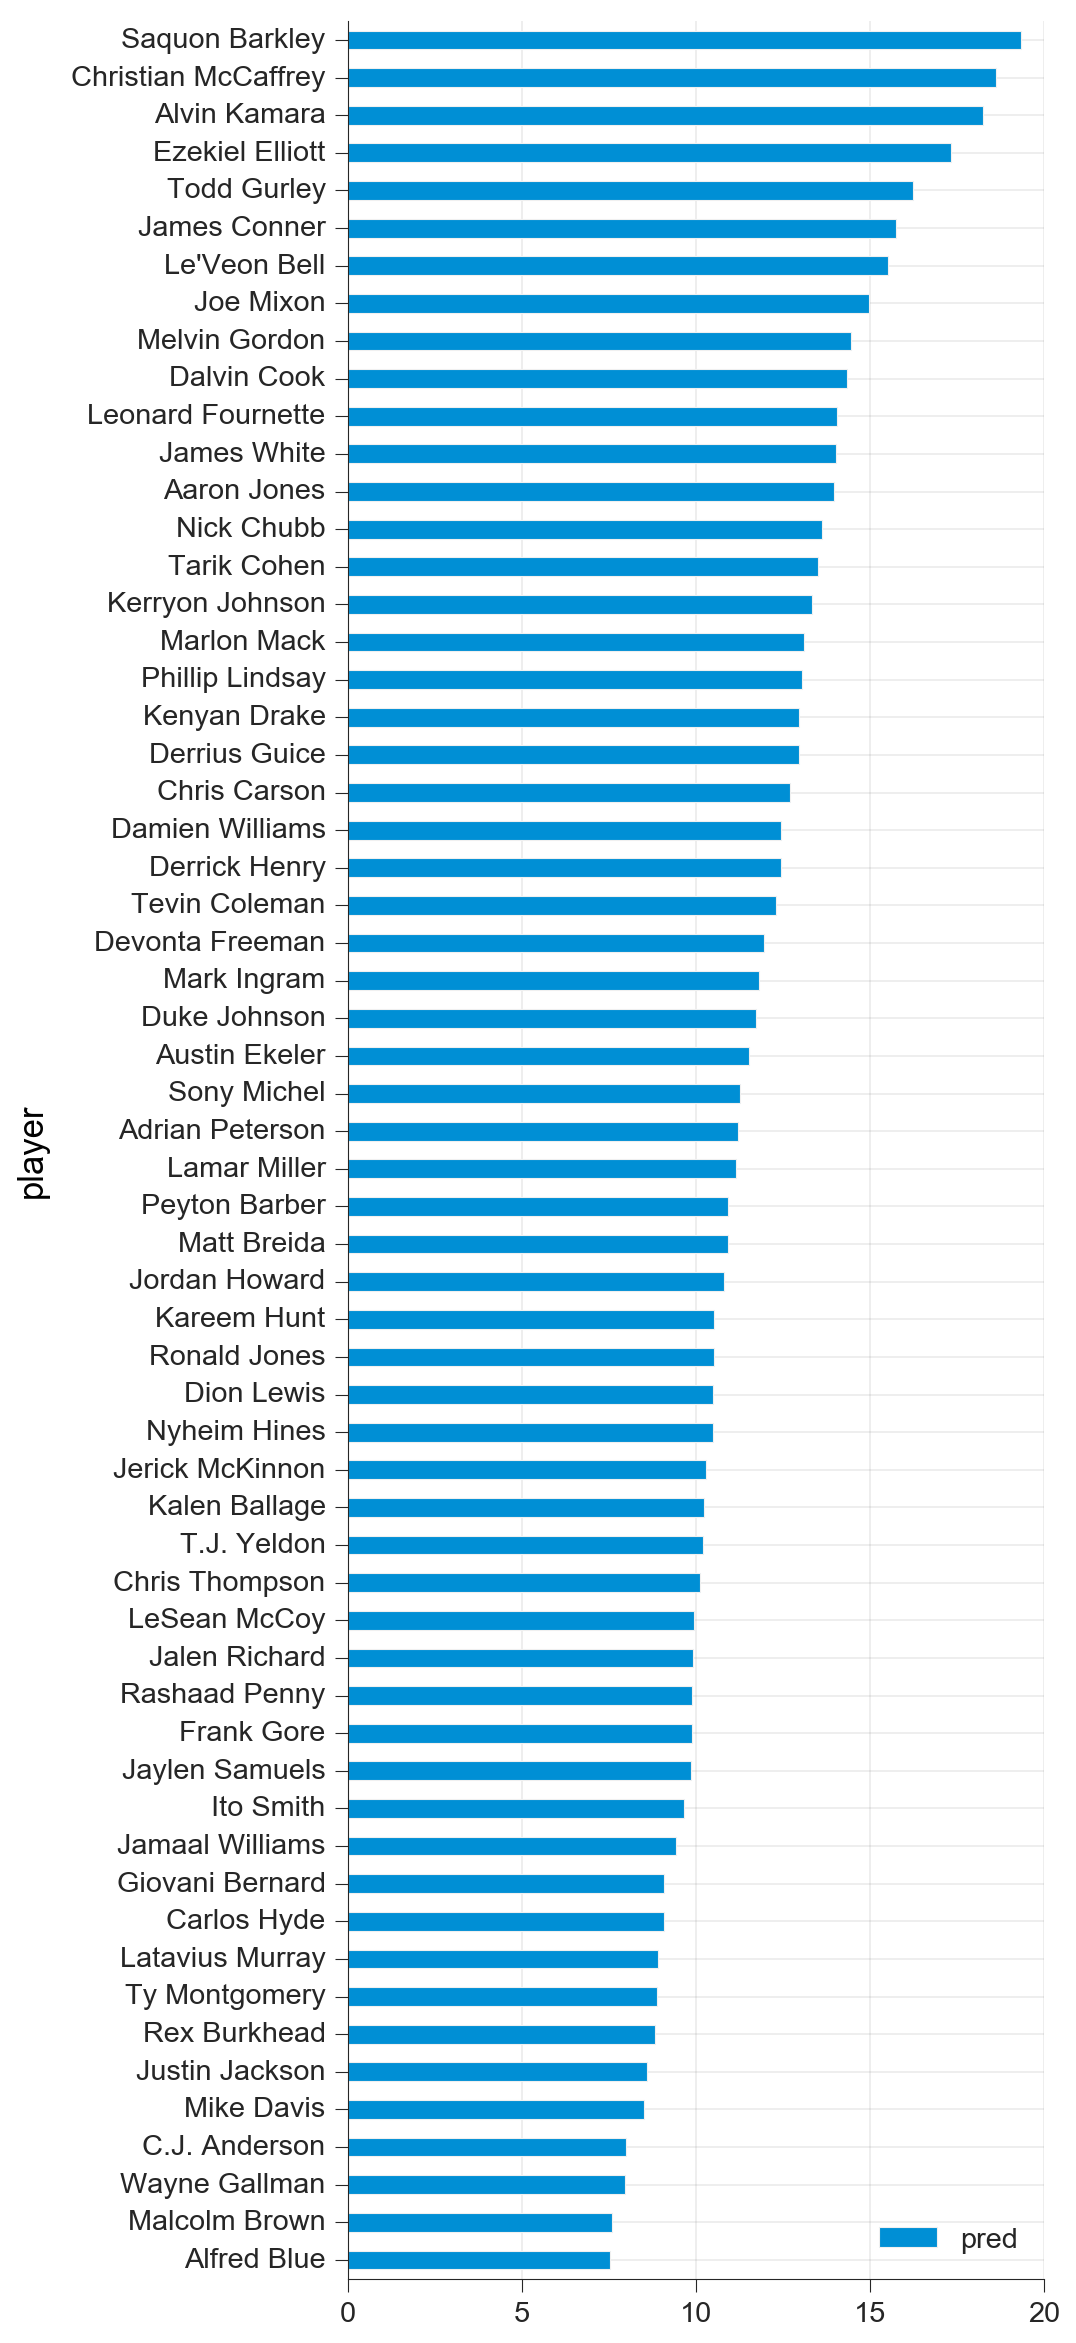

In [91]:
#--------
# Calculate Fantasy Points for Given Scoring System
#-------- 

# extract points list and get the idx of point attributes based on length of list
pts_list = pts_dict[set_pos]
c_idx = len(pts_list) + 2

train_plot = df_train_results.copy()
test_plot = df_test_results.copy()

# multiply stat categories by corresponding point values
train_plot.iloc[:, 2:c_idx] = train_plot.iloc[:, 2:c_idx] * pts_list
test_plot.iloc[:, 2:c_idx] = test_plot.iloc[:, 2:c_idx] * pts_list

# add a total predicted points stat category
train_plot.loc[:, 'pred'] = train_plot.iloc[:, 2:c_idx].sum(axis=1)
test_plot.loc[:, 'pred'] = test_plot.iloc[:, 2:c_idx].sum(axis=1)

#==========
# Plot Predictions for Each Player
#==========

# set length of plot based on number of results
plot_length = int(test_plot.shape[0] / 3.5)

# plot results from highest predicted FP to lowest predicted FP
test_plot.sort_values('pred').plot.barh(x='player', y='pred', figsize=(5, plot_length));

#==========
# If desired, plot feature importances for a given metric / model
#==========
plot_importance=True
if plot_importance == True:
    
    metric = 'rec_yd_per_game'
    j = 3
    try:
        plot_results(output[metric]['models'][j].feature_importances_, col_names=output[metric]['cols']);
    except:
        plot_results(output[metric]['models'][j].coef_, col_names=output[metric]['cols']);

# Comparing Fantasy Pros

In [92]:
# create training and prediction dataframes
fantasy_points = []

for m in pos[set_pos]['metrics']:
    df_train_full, df_predict_full = features_target(df,
                                                     earliest_year, set_year-1,
                                                     pos[set_pos]['med_features'],
                                                     pos[set_pos]['sum_features'],
                                                     pos[set_pos]['max_features'],
                                                     pos[set_pos]['age_features'],
                                                     target_feature=m)
    fantasy_points.append(list(df_train_full.y_act.values))
    
fantasy_pts = pd.DataFrame(fantasy_points).T.reset_index(drop=True)
fantasy_pts = (fantasy_pts * pts_dict[set_pos]).sum(axis=1)
fantasy_pts.name = 'fantasy_pts'

In [93]:
stats_fp = []
stats_all = []
min_year = int(max(df_train_results.year.min(), 2012))
    
for metric in pos[set_pos]['metrics']:

    df_train_full, df_predict_full = features_target(df,
                                                         earliest_year, set_year-1,
                                                         pos[set_pos]['med_features'],
                                                         pos[set_pos]['sum_features'],
                                                         pos[set_pos]['max_features'],
                                                         pos[set_pos]['age_features'],
                                                         target_feature=metric)

    df_train_full = pd.concat([df_train_full, fantasy_pts], axis=1)

    fp = pd.read_sql_query('SELECT * FROM FantasyPros', con=sqlite3.connect('/Users/Mark/Documents/Github/Fantasy_Football/Data/Season_Stats.sqlite3'))
    fp.year = fp.year-1
    df_train_full = pd.merge(df_train_full, fp, how='inner', left_on=['player', 'year'], right_on=['player', 'year'])
    df_train_full = df_train_full[df_train_full.fp > 5]


    from sklearn.linear_model import Lasso
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import mean_squared_error
    from sklearn.linear_model import Ridge


    df_train_full = df_train_full.dropna()
    lass = Lasso(alpha=250)
#     y = 'fantasy_pts'
#     y_other = 'y_act'
    
    y_other = 'fantasy_pts'
    y = 'y_act'


    stat_all = []
    stat_fp = []
    results_all = []
    results_fp = []
    for i in range(min_year, (set_year-1)):

        print(i)
        X_train = df_train_full.loc[df_train_full.year < i].drop([y_other, y], axis=1)
        y_train = df_train_full.loc[df_train_full.year < i, y]

        X_fp = X_train[['year', 'rank', 'adp', 'best', 'worst', 'avg', 'std_dev']]
        X_all = X_train.drop(['player', 'team', 'pos','rank', 'adp', 'best', 'worst', 'avg', 'std_dev' ], axis=1)

        X_predict = df_train_full.loc[df_train_full.year== i].drop([y_other, y], axis=1)
        X_pred_fp = X_predict[['year', 'rank', 'adp', 'best', 'worst', 'avg', 'std_dev']]
        X_pred_all = X_predict.drop(['player', 'team', 'pos', 'rank', 'adp', 'best', 'worst', 'avg', 'std_dev'], axis=1)

        y_pred = df_train_full.loc[df_train_full.year == i, y]

        lass.fit(X_fp, y_train)
        fp_pred = lass.predict(X_pred_fp)
        stat_fp.extend(list(fp_pred))
        print('FP error:', round(np.mean(np.sqrt(abs(mean_squared_error(fp_pred, y_pred)))), 3))
        results_fp.append(round(np.mean(np.sqrt(abs(mean_squared_error(fp_pred, y_pred)))), 3))

        lass.fit(X_all.replace([np.inf, -np.inf], np.nan).fillna(0), y_train)
        all_pred = lass.predict(X_pred_all.replace([np.inf, -np.inf], np.nan).fillna(0))
        stat_all.extend(list(all_pred))
        print('All error:', round(np.mean(np.sqrt(abs(mean_squared_error(all_pred, y_pred)))), 3))
        results_all.append(round(np.mean(np.sqrt(abs(mean_squared_error(all_pred, y_pred)))), 3))
    
    stats_fp.append(stat_fp)
    stats_all.append(stat_all)
    
    if y == 'fantasy_pts':
        print('--------------')
        print('Fantasy Pros straight FP Error:', round(np.mean(results_fp), 3))
        print('All straight FP Error:', round(np.mean(results_all), 3))
        break

2012
FP error: 19.066
All error: 21.347
2013
FP error: 13.839
All error: 22.194
2014
FP error: 17.751
All error: 16.496
2015
FP error: 16.276
All error: 19.894
2016
FP error: 14.333
All error: 15.444
2017
FP error: 18.377
All error: 17.234
2012
FP error: 13.324
All error: 10.711
2013
FP error: 13.515
All error: 13.079
2014
FP error: 10.905
All error: 10.264
2015
FP error: 12.323
All error: 9.122
2016
FP error: 13.093
All error: 10.677
2017
FP error: 14.224
All error: 12.281
2012
FP error: 1.565
All error: 1.407
2013
FP error: 1.494
All error: 1.554
2014
FP error: 1.254
All error: 1.273
2015
FP error: 1.292
All error: 1.261
2016
FP error: 1.287
All error: 1.214
2017
FP error: 1.533
All error: 1.481
2012
FP error: 0.288
All error: 0.279
2013
FP error: 0.284
All error: 0.289
2014
FP error: 0.21
All error: 0.204
2015
FP error: 0.346
All error: 0.342
2016
FP error: 0.293
All error: 0.296
2017
FP error: 0.36
All error: 0.361


In [94]:
#----------------
# Convert Fantasy Pros and Lasso Stat Results to Points
#----------------

df_all = pd.DataFrame(stats_all).T
df_fp = pd.DataFrame(stats_fp).T
    
df_all = (df_all * pts_dict[set_pos]).sum(axis=1)
df_fp = (df_fp * pts_dict[set_pos]).sum(axis=1)

y_test = df_train_full.loc[(df_train_full.year <= i) & (df_train_full.year >= min_year), y_other]

print('Lasso error:', round(np.mean(np.sqrt(abs(mean_squared_error(df_all, y_test)))), 2))
print('FantasyPros error:', round(np.mean(np.sqrt(abs(mean_squared_error(df_fp, y_test)))), 2))

#----------------
# Merge Fantasy Pros Data with Full Model Results to get Matching Player Sets
#----------------

full_models = pd.merge(
              df_train_full.loc[(df_train_full.year <= i) & (df_train_full.year >= min_year), ['player', 'year']],
              df_train_results, 
              how='inner', left_on=['player', 'year'], right_on=['player', 'year']).reset_index(drop=True)

y_test = df_train_full.loc[(df_train_full.year <= i) & (df_train_full.year >= min_year), y_other].reset_index(drop=True)

if set_pos == 'RB':
    pts = pts_dict[set_pos]
    full_models['fantasy_pts'] = (full_models.iloc[:,2:(len(pts)+2)]* pts).sum(axis=1)

elif set_pos == 'WR' or set_pos =='TE':
    pts = pts_dict[set_pos]
    full_models['fantasy_pts'] = (full_models.iloc[:,2:(len(pts)+2)]*pts).sum(axis=1)
    
elif set_pos == 'QB':
    pts = pts_dict[set_pos]
    full_models['fantasy_pts'] = (full_models.iloc[:,2:(len(pts)+2)]* pts).sum(axis=1)

Lasso error: 4.55
FantasyPros error: 4.34


In [95]:
print('All Models:', round(np.mean(np.sqrt(abs(mean_squared_error(full_models.fantasy_pts, y_test)))), 2))

All Models: 3.76


## RB Compare

### No Air Yards (Large Dataset)

In [31]:
(4.34-3.74) / (np.mean([4.34, 3.74]))

0.14851485148514842

## WR Compare

### No Air Yards (Large Dataset)

In [100]:
(3.18 - 2.76) / (np.mean([3.18, 2.76]))

0.14141414141414155

## TE Compare

In [99]:
(2.73-2.46) / (np.mean([2.73, 2.46]))

0.10404624277456649

## QB Compare

In [119]:
(2.66 - 2.62) / (np.mean([2.66, 2.62]))

0.015151515151515164

## Write out results to Postgres

In [120]:
#--------
# Append additional stat categories to the results
#--------

# add actual results and adp to the train df
train_results = pd.merge(df_train_results, df[['player', 'year', 'age', 'year_exp', 'avg_pick']],
                           how='inner', left_on=['player', 'year'], right_on=['player', 'year'])

# add adp to the test df
test_results = pd.merge(df_test_results, df[['player', 'year', 'age', 'year_exp', 'avg_pick']],
                           how='inner', left_on=['player', 'year'], right_on=['player', 'year'])

#--------
# Set up proper database connections to save out single dataset
#--------

train_results.to_sql(set_pos + '_Train_' + str(set_year), engine, schema='websitedev', index=False, if_exists='replace')
test_results.to_sql(set_pos + '_Test_' + str(set_year), engine, schema='websitedev', index=False, if_exists='replace')

# Break Out Model

In [ ]:
shift_df = df.copy()
shift_df.year = shift_df.year - 1
shift_df = shift_df[['player', 'year', 'fp_per_game']].rename(columns={'fp_per_game': 'y_act'})
outlier = pd.merge(df, shift_df, how='inner', 
                   left_on=['player', 'year'], right_on=['player', 'year'])
outlier = outlier[outlier.games >= 8].reset_index(drop=True)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

output = pd.DataFrame()
for yy in range(int(outlier.year.min()+3), int(outlier.year.max()+1)):
    X = outlier[outlier.year < yy].avg_pick.values.reshape(-1, 1)
    y = outlier[outlier.year < yy].y_act
    
    lr.fit(X, y)
    pred = lr.predict(outlier[outlier.year == yy].avg_pick.values.reshape(-1, 1))
    output_tmp = outlier.loc[outlier.year == yy, ['player', 'year', 'avg_pick', 'y_act']].reset_index(drop=True)
    output_tmp = pd.concat([output_tmp, pd.Series(pred)], axis=1)
    
    output = pd.concat([output, output_tmp], axis=0)
    
output = output.rename(columns={0: 'avg_pick_pred'})

In [ ]:
output['pct_off'] = (output.y_act - output.avg_pick_pred) / output.avg_pick_pred
output['avg_pick'] = np.exp(output.avg_pick)
output = output[(output.pct_off > .20) & (output.avg_pick > 50) & (output.y_act > 11)].reset_index(drop=True)

In [ ]:
output['label'] = 1
output = output[['player', 'year', 'label']]

outlier = outlier.drop('y_act', axis=1)
outlier = pd.merge(outlier, output, how='left', left_on=['player', 'year'], right_on=['player', 'year'])
outlier = outlier.fillna(0)

outlier = outlier[np.exp(outlier.avg_pick) > 50]

In [ ]:
rookie_rb  = pd.read_sql_query('SELECT * FROM Rookie_RB_Stats', 
                               con=sqlite3.connect('/Users/Mark/Documents/Github/Fantasy_Football/Data/Season_Stats.sqlite3'))

In [ ]:
rookie_rb = rookie_rb.drop(['pp_age', 'draft_year', 'rush_yd_per_game', 'rec_yd_per_game', 
                            'rec_per_game', 'td_per_game',
                            'team', 'avg_pick', 'log_avg_pick'], axis=1)

In [ ]:
outlier = pd.merge(outlier, rookie_rb, how='inner', left_on='player', right_on='player')

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

m1 = LGBMClassifier(max_depth=3, subsample=1, 
                   n_estimators=25, class_weight='balanced',
                   min_child_samples=10, feature_fraction=1)


m2 = RandomForestClassifier(max_depth=2, min_samples_leaf=5, max_features=0.9,
                           n_estimators=20, class_weight='balanced', random_state=1234
                           )

# m2 = XGBClassifier(max_depth=5, subsample=1, 
#                    n_estimators=30, class_weight='balanced',
#                    min_child_samples=2, min_child_split=5, feature_fraction=.9)

m3 = LogisticRegression(C = 5)

output = pd.DataFrame()
for yy in range(int(outlier.year.min()+4), int(outlier.year.max()+1)):
    X = outlier[outlier.year < yy].drop(['player', 'pos', 'team', 'label', 'last_year'], axis=1)
    y = outlier[outlier.year < yy].label
    output_tmp = outlier.loc[outlier.year == yy, ['player', 'year', 'label']].reset_index(drop=True)


    m1.fit(X, y)
    pred1 = m1.predict(outlier[outlier.year == yy].drop(['player', 'pos', 'team', 'label', 'last_year'], axis=1))
    output_tmp = pd.concat([output_tmp, pd.Series(pred1, name='m1')], axis=1)
    
    m2.fit(X, y)
    pred2 = m2.predict(outlier[outlier.year == yy].drop(['player', 'pos', 'team', 'label', 'last_year'], axis=1))
    output_tmp = pd.concat([output_tmp, pd.Series(pred2, name='m2')], axis=1)
    
    m3.fit(X, y)
    pred3 = m3.predict(outlier[outlier.year == yy].drop(['player', 'pos', 'team', 'label', 'last_year'], axis=1))
    output_tmp = pd.concat([output_tmp, pd.Series(pred3, name='m3')], axis=1)
    
    output = pd.concat([output, output_tmp], axis=0)
    
print(f1_score(output.label, output.m1))

In [ ]:
output['pred'] = 0
output['total'] = output.m1 + output.m2 + output.m3
output.loc[output.total >= 2, 'pred'] = 1

In [ ]:
print(f1_score(output.label, output.pred))

In [ ]:
output[output.year == 2017].sort_values(by='total').sort_values(by='total')

In [ ]:
this_year = df[(df.year == 2018) & (np.exp(df.avg_pick) > 50)].reset_index(drop=True)
ty = pd.concat([this_year[['player', 'year']], 
                pd.Series(m1.predict(this_year.drop(['player', 'pos', 'team', 'last_year'], axis=1)), name='m1'),
                pd.Series(m2.predict(this_year.drop(['player', 'pos', 'team', 'last_year'], axis=1)), name='m2'),
                pd.Series(m3.predict(this_year.drop(['player', 'pos', 'team', 'last_year'], axis=1)), name='m3')], 
               axis=1)

ty['total'] = ty.m1 + ty.m2 + ty.m3

In [ ]:
ty.sort_values(by='total', ascending=False)

# Creating Salary, Injury Tables and SQLite Output

### Push Salary to DB

In [121]:
sal = pd.read_csv('/Users/Mark/Documents/GitHub/Fantasy_Football/Data/OtherData/Salaries/salaries_2019_nv.csv')
sal.to_sql('salaries_' + str(set_year), engine, schema='websitedev', index=False, if_exists='replace')

### Push Injuries to DB

In [122]:
from sklearn.preprocessing import StandardScaler

inj = pd.read_csv('/Users/Mark/Documents/GitHub/Fantasy_Football/Data/OtherData/InjuryPredictor/injury_predictor_2019_v2.csv',  
                  encoding='latin-1', header=None)
inj.columns = ['player', 'pct_miss_one', 'proj_games_missed', 'inj_pct_per_game', 'inj_risk', 'points']
inj.player = inj.player.apply(lambda x: x.split(',')[0])
inj.pct_miss_one = inj.pct_miss_one.apply(lambda x: float(x.strip('%')))
inj.inj_pct_per_game = inj.inj_pct_per_game.apply(lambda x: float(x.strip('%')))
inj = inj.drop(['points', 'inj_risk'], axis=1)

X = StandardScaler().fit_transform(inj.iloc[:, 1:])
inj = pd.concat([pd.DataFrame(inj.player), 
                 pd.DataFrame(X, columns=['pct_miss_one', 'proj_games_missed', 'pct_per_game'])], 
                axis=1)
for col in ['pct_miss_one', 'proj_games_missed', 'pct_per_game']:
    inj[col] = inj[col] + abs(inj[col].min())

inj['mean_risk'] = inj.iloc[:, 1:].mean(axis=1)
inj = inj[['player', 'mean_risk']].sort_values(by='mean_risk').reset_index(drop=True)
inj.loc[inj.player=='Kareem Hunt', 'mean_risk'] = 8
inj.loc[inj.player=='Melvin Gordon', 'mean_risk'] = inj.loc[inj.player=='Melvin Gordon', 'mean_risk'] + 4
inj.loc[inj.player=='Ezekiel Elliott', 'mean_risk'] = inj.loc[inj.player=='Ezekiel Elliott', 'mean_risk'] + 2
inj.loc[inj.player=='Todd Gurley', 'mean_risk'] = inj.loc[inj.player=='Todd Gurley', 'mean_risk'] + 1
inj.loc[inj.player=='Antonio Brown', 'mean_risk'] = inj.loc[inj.player=='Antonio Brown', 'mean_risk'] + 1
inj.loc[inj.player=='Derrius Guice', 'mean_risk'] = inj.loc[inj.player=='Derrius Guice', 'mean_risk'] + 1
inj.loc[inj.player=='A.J. Green', 'mean_risk'] = inj.loc[inj.player=='A.J. Green', 'mean_risk'] + 2


inj = inj[['player', 'mean_risk']]
inj.to_sql('injuries_' + str(set_year), engine, schema='websitedev', index=False, if_exists='replace')

### Drop All Data into SQLite Database

In [ ]:
db = sqlite3.connect('/Users/Mark/Desktop/FF_Sim/SimInput_v2.sqlite3')

for set_pos in ['QB', 'RB', 'WR', 'TE']:
    
    train = pd.read_sql_query('SELECT * FROM {}."{}_Train_{}"' \
                                     .format(table_info['schema'], set_pos, str(set_year)), table_info['engine'])
    test = pd.read_sql_query('SELECT * FROM {}."{}_Test_{}"' \
                                    .format(table_info['schema'], set_pos, str(set_year)), table_info['engine'])
    
    train.to_sql(name='{}_Train_{}'.format(set_pos, str(set_year)), con=db, if_exists='replace', index=False)
    test.to_sql(name='{}_Test_{}'.format(set_pos, str(set_year)), con=db, if_exists='replace', index=False)
    

sal = pd.read_sql_query('SELECT * FROM {}."salaries_2019"' \
                                    .format(table_info['schema'], set_pos, str(set_year)), table_info['engine'])
sal.to_sql(name='salaries_2019', con=db, if_exists='replace', index=False)

inj = pd.read_sql_query('SELECT * FROM {}."injuries_2019"' \
                                    .format(table_info['schema'], set_pos, str(set_year)), table_info['engine'])
inj.to_sql(name='injuries_2019', con=db, if_exists='replace', index=False)